# Data analysis: Covid cases over time

Data analysis of daily new covid cases in different countries, using data from:

https://github.com/CSSEGISandData/COVID-19

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import itertools
import pycountry

from datetime import datetime, timedelta

In [2]:
plt.style.use("dark_background")

In [3]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 200

## Import and clean up data

In [4]:
def read_csv(file, response):
    return (
        pd.read_csv(file)
        # Remove unused columns
        .drop(["Lat", "Long"], axis=1)
        # Rename the columns
        .rename(columns={"Country/Region": "country", "Province/State": "province"})
        # Make the date a column
        .melt(id_vars=["province", "country"], var_name="date", value_name=response)
        # Convert the date from string to a real date
        .assign(**{"date": lambda df: pd.to_datetime(df["date"], format="%m/%d/%y")})
        # Aggregate provinces
        .drop(columns=["province"])
        .groupby(["country", "date"])
        .sum()
        # Convert cumulative totals to daily increments
        .groupby(level="country")
        .diff()
    )

In [5]:
cases_df = read_csv("time_series_covid19_confirmed_global.csv", "cases")

In [6]:
cases_df.head(5)

cases
country     date             
Afghanistan 2020-01-22    NaN
            2020-01-23    0.0
            2020-01-24    0.0
            2020-01-25    0.0
            2020-01-26    0.0

In [7]:
deaths_df = read_csv("time_series_covid19_deaths_global.csv", "deaths")

In [8]:
deaths_df.head(5)

deaths
country     date              
Afghanistan 2020-01-22     NaN
            2020-01-23     0.0
            2020-01-24     0.0
            2020-01-25     0.0
            2020-01-26     0.0

Read population data from https://data.worldbank.org/indicator/SP.POP.TOTL?view=chart:

In [9]:
pop_df = (
    pd.read_csv("worldbank_pop.csv")
    .loc[:, ["Country Code", "2020"]]
    .assign(pop_mln=lambda df: df["2020"]/1_000_000)
    .rename(columns={"Country Code": "country_code"})
    .loc[:, ["country_code", "pop_mln"]]
    .set_index("country_code")
    .sort_index()
)

In [10]:
pop_df.head(3)

,pop_mln
country_code,
ABW,0.106766
AFE,677.243299
AFG,38.928341


Map country names from the John-Hopkins University Covid datasets to three letter ISO codes using pycountry:

In [11]:
country_names = cases_df.index.unique(level="country")
country_names_to_codes = {}
country_names_unmapped = []
for country_name in country_names:
    try:
        search_results = pycountry.countries.search_fuzzy(country_name)
        country_names_to_codes[country_name] = search_results[0].alpha_3
    except LookupError:
        country_names_unmapped.append(country_name)

country_names_to_codes = pd.Series(country_names_to_codes, name="country_code")
country_names_to_codes.head(5)

Afghanistan    AFG
Albania        ALB
Algeria        DZA
Andorra        AND
Angola         AGO
Name: country_code, dtype: object

Country names that could not be mapped:

In [12]:
country_names_unmapped

['Burma',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Diamond Princess',
 'Korea, South',
 'Laos',
 'MS Zaandam',
 'Summer Olympics 2020',
 'Taiwan*',
 'West Bank and Gaza']

Join all the dataframes:

In [13]:
df = (
    cases_df.join(deaths_df)
    .join(country_names_to_codes, on="country", how="inner")
    .join(pop_df, on="country_code", how="inner")
    .drop(columns="country_code")
    .loc[lambda df: df["pop_mln"].notna()]
    .assign(cases_per_mln=lambda df: df["cases"] / df["pop_mln"],
            deaths_per_mln=lambda df: df["deaths"] / df["pop_mln"])
    .sort_index()
)

In [14]:
df.groupby("country").tail(1).head(30)

,,cases,deaths,pop_mln,cases_per_mln,deaths_per_mln
country,date,,,,,
Afghanistan,2021-12-04,19.0,1.0,38.928341,0.488076,0.025688
Albania,2021-12-04,357.0,1.0,2.837743,125.804204,0.352393
Algeria,2021-12-04,185.0,7.0,43.851043,4.218828,0.159631
Andorra,2021-12-04,0.0,0.0,0.077265,0.000000,0.000000
Angola,2021-12-04,21.0,0.0,32.866268,0.638953,0.000000
Antigua and Barbuda,2021-12-04,1.0,0.0,0.097928,10.211584,0.000000
Argentina,2021-12-04,1690.0,4.0,45.376763,37.243732,0.088151
Armenia,2021-12-04,419.0,25.0,2.963234,141.399565,8.436728
Australia,2021-12-04,1249.0,8.0,25.687041,48.623740,0.311441


Countries where the population could not be joined and are hence not included in the final dataframe:

In [15]:
set(cases_df.index.unique(level="country")) - set(df.index.unique(level="country"))

{'Burma',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Diamond Princess',
 'Eritrea',
 'Holy See',
 'Korea, South',
 'Laos',
 'MS Zaandam',
 'Summer Olympics 2020',
 'Taiwan*',
 'West Bank and Gaza'}

## Analyze

In [16]:
countries = sorted([
    "US",
    "Germany",
    "United Kingdom",
    "Russia",
    "Poland",
    "Ukraine",
    "Czechia"
])

### Moving average of cases and deaths

In [17]:
def moving_average(df):
    return df.groupby(level="country", group_keys=False).apply(lambda s: s.rolling(7).mean())

In [18]:
def plot_moving_average(df, countries, date_from, date_to, response, plot_title):
    plot_df = (
        moving_average(df)
        .loc[(countries, slice(date_from, date_to)), response]
        .unstack(level="country")
    )

    fig, ax = plt.subplots(figsize=(16,5))
    for col in plot_df.columns:
        ax.plot(plot_df.index, plot_df[col], label=col)
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
    ax.set_title(plot_title)

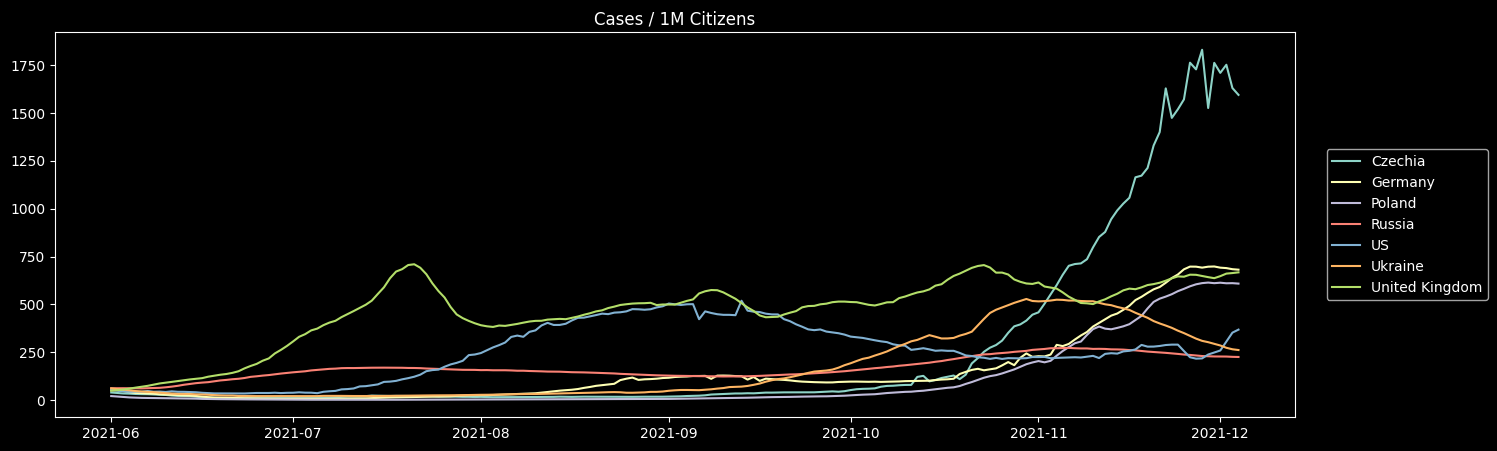

In [19]:
plot_moving_average(
    df=df,
    countries=countries,
    date_from=pd.to_datetime("2021-06-01"),
    date_to=pd.to_datetime("2021-12-31"),
    response="cases_per_mln",
    plot_title="Cases / 1M Citizens"
)

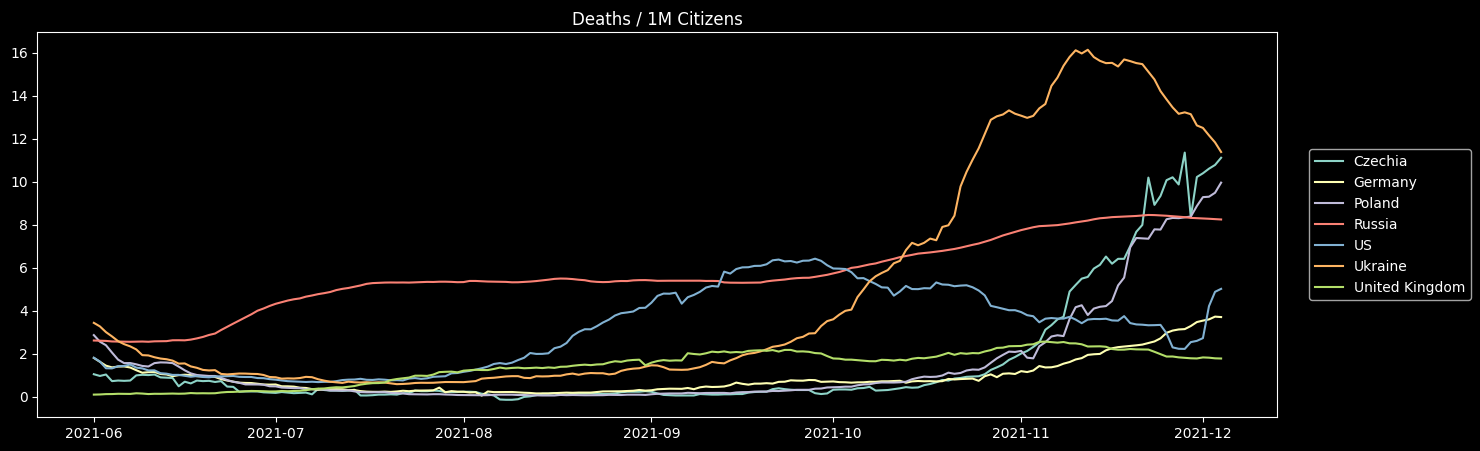

In [20]:
plot_moving_average(
    df=df,
    countries=countries,
    date_from=pd.to_datetime("2021-06-01"),
    date_to=pd.to_datetime("2021-12-31"),
    response="deaths_per_mln",
    plot_title="Deaths / 1M Citizens"
)

### Compare 2020 and 2021

In [21]:
def moving_average_with_1y_shift(df):
    mavg = moving_average(df)
    mavg_1y_ago = mavg.groupby(level="country").shift(365)
    return mavg.join(mavg_1y_ago, rsuffix="_1y_ago")

In [22]:
def plot_moving_average_with_1y_shift(df, countries, date_from, date_to):
    plot_df = moving_average_with_1y_shift(df).loc[(countries, slice(date_from, date_to)), :]

    countries = plot_df.index.unique(level="country")
    responses = ["cases_per_mln", "deaths_per_mln"]

    fig, axs = plt.subplots(
        figsize=(16, 28),
        tight_layout=True,
        nrows=len(countries),
        ncols=len(responses),
        sharex=True,
        sharey="col"
    )

    x_locator = mpl.dates.MonthLocator()
    x_formatter = mpl.dates.DateFormatter("%b %d")

    for ax, (country, response) in zip(axs.flat, itertools.product(countries, responses)):
        country_df = plot_df.loc[country, :]

        ax.plot(country_df.index, country_df[f"{response}_1y_ago"], color="grey", linestyle="dashed", label=str(date_from.year-1))
        ax.plot(country_df.index, country_df[response], label=str(date_from.year))

        ax.set_title(f"{country} - {response}")
        ax.set_xlim(date_from, date_to)
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        ax.xaxis.set_tick_params(labelbottom=True, rotation=45)
        ax.legend(loc="upper center", ncol=2)

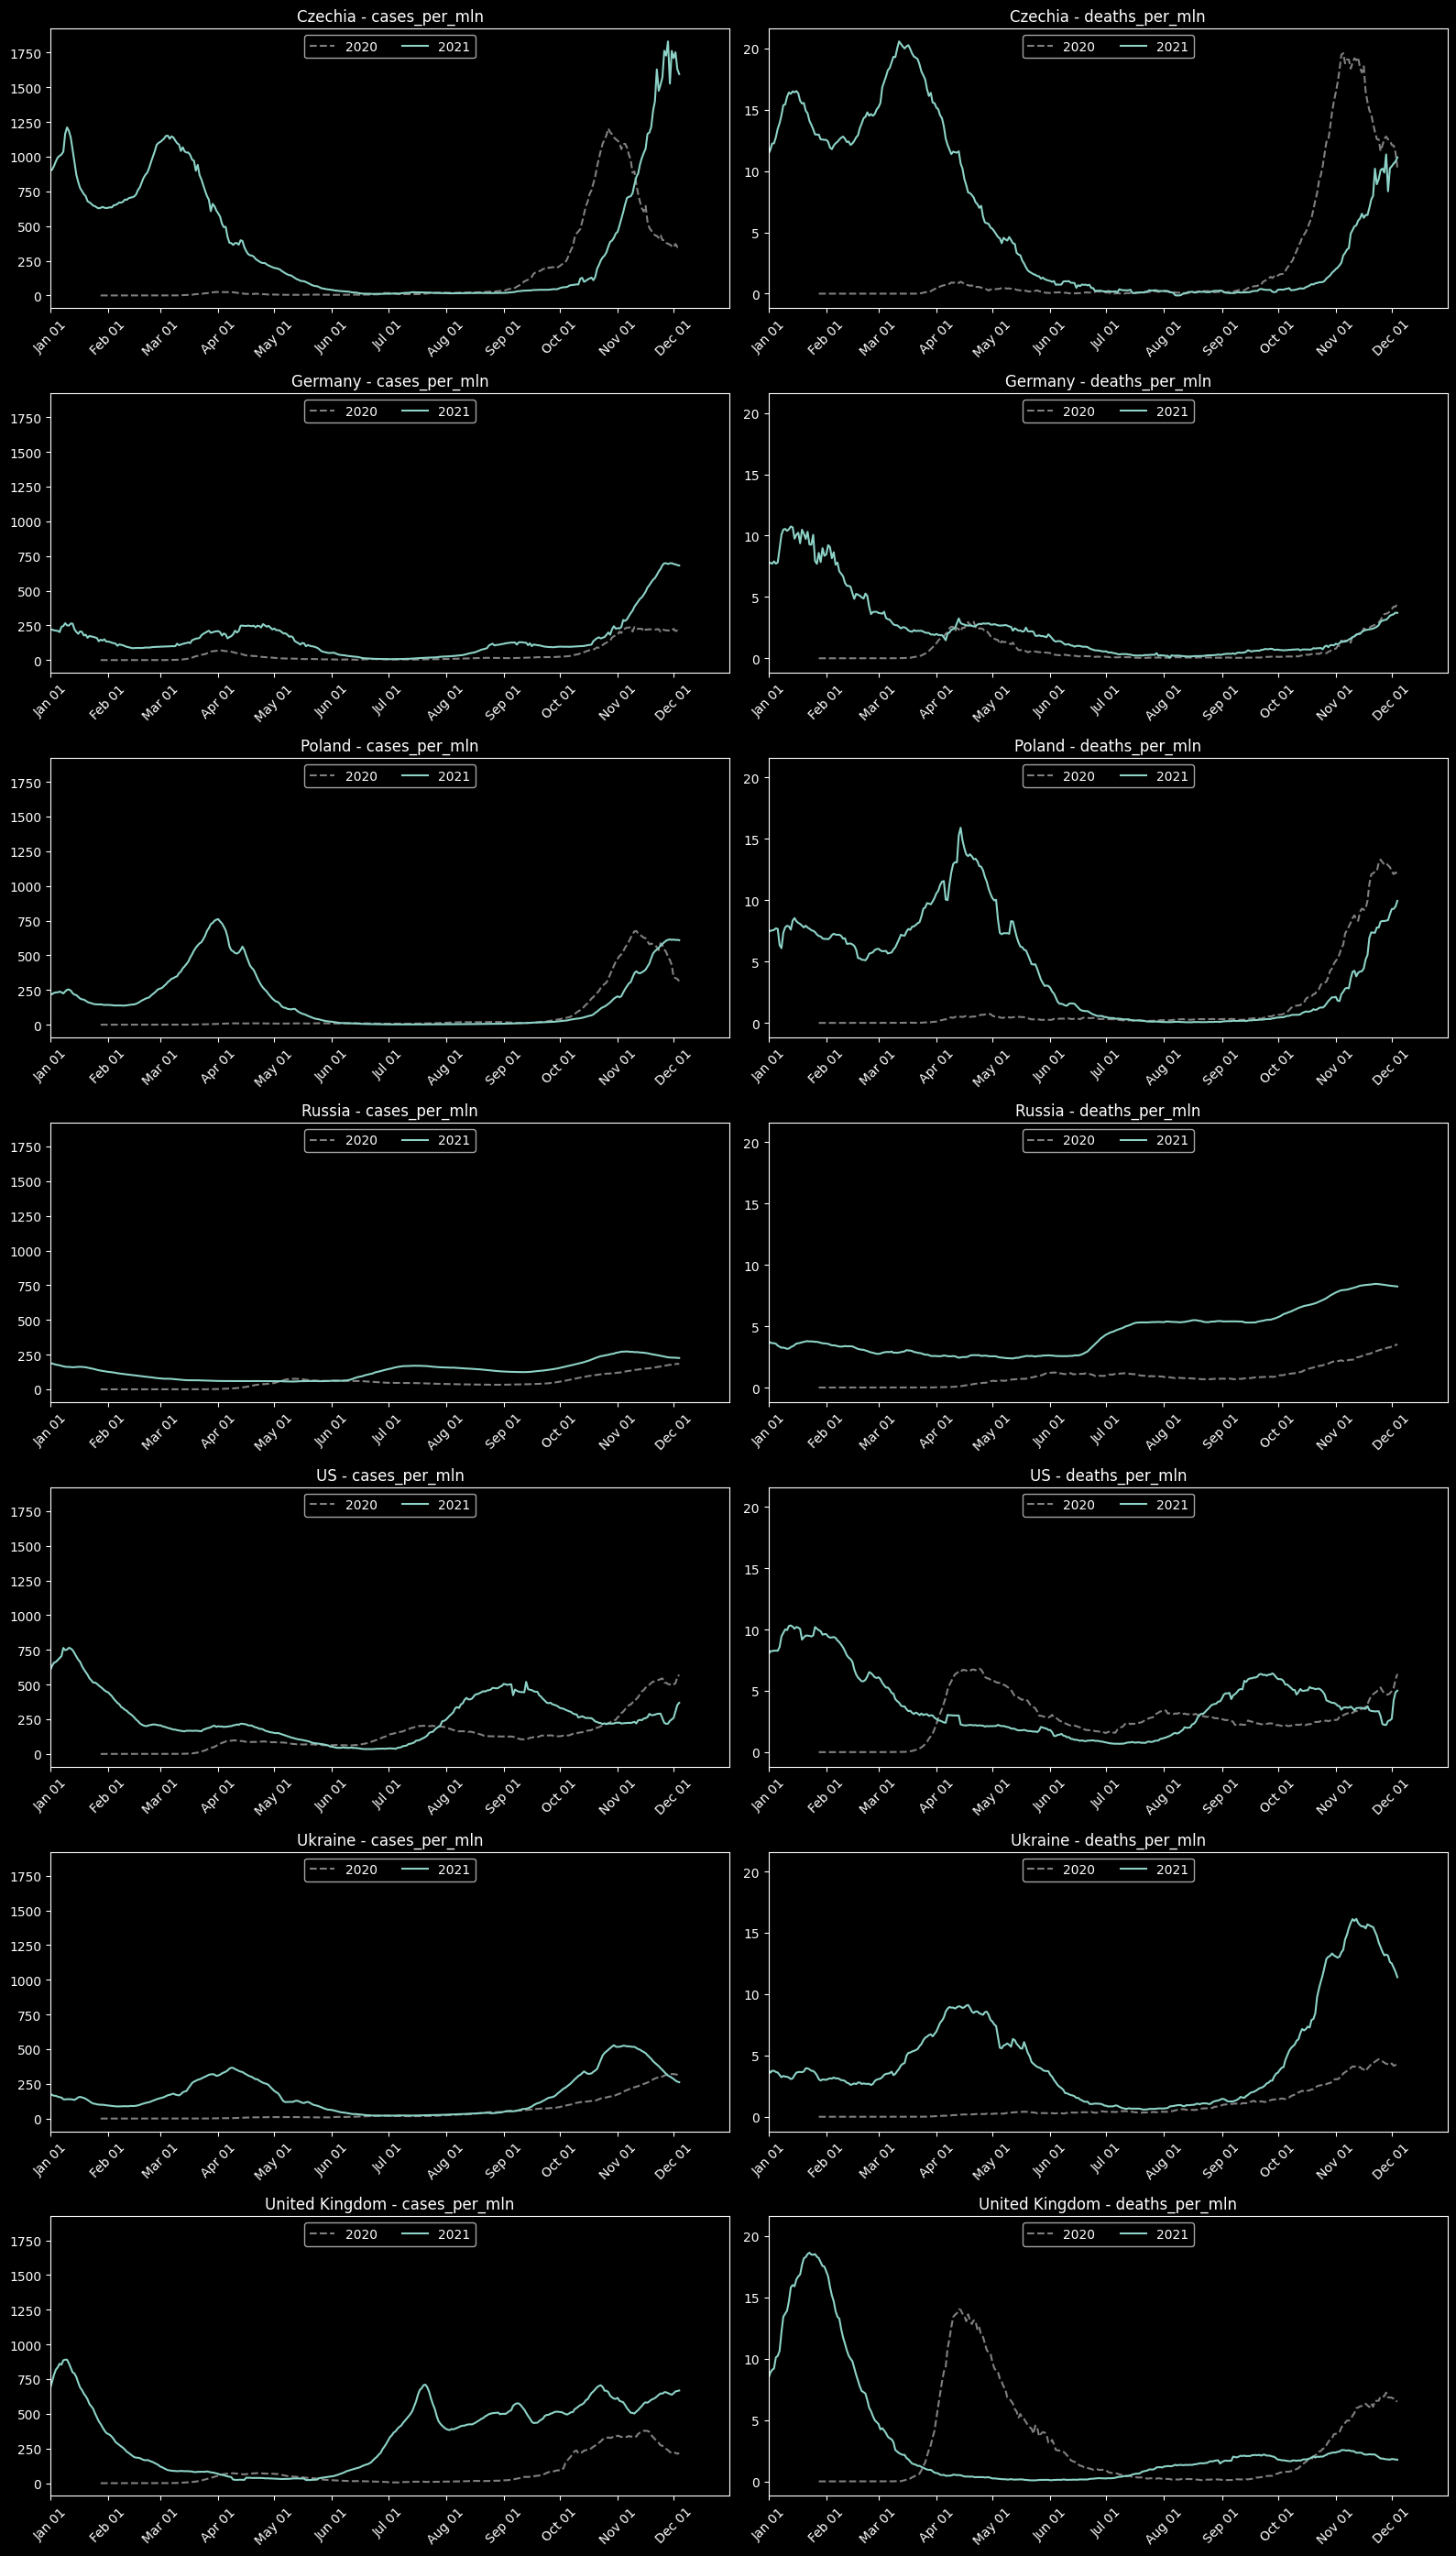

In [23]:
plot_moving_average_with_1y_shift(
    df=df,
    countries=countries,
    date_from=pd.to_datetime("2021-01-01"),
    date_to=pd.to_datetime("2021-12-31")
)